In [73]:
import numpy as np
import sys
sys.path.append('../')
from symmetry_breaking_measure import Nickel, RotationOperator
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import pandas as pd
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The violation of symmetry elements of local distorted Nickel

## Sample Size

In [74]:
# Cubic solid cut off from Nickel (length=1)
NUM_SAMPLES = 50000
NUM_D = 50
NUM_ANGLES = 8
CONFIDENCE_LEVEL = .95
TOLERANCE_ONE_SIDE = .0025

nickel = Nickel(cutoff='rectangular_solid', cutout_x=1, cutout_y=1, cutout_z=1)
axis = [0,0,1]
origin = nickel.xyz.mean(axis=0)
rotation_op = RotationOperator(axis=axis, origin=origin)

atoms_idx_center = np.any(nickel.xyz == nickel.lattice.a/2, axis=1)
unique_rows, indices = np.unique(nickel.xyz[atoms_idx_center], axis=0, return_index=True)
atoms_idx_center = np.where(atoms_idx_center)[0][indices]
atoms_idx_corner = np.setdiff1d(np.arange(nickel.xyz.shape[0]), atoms_idx_center)

In [77]:
def perturbation_0_degree(radius=None, num_of_tests=None):
    #phi = np.linspace(0, 2 * np.pi, num_of_tests+1)[:-1]
    phi = np.array([0, np.pi / 4])
    x = np.cos(phi)
    y = np.sin(phi)
    #z = np.zeros(num_of_tests)
    z = np.zeros(2)
    result = np.column_stack((x, y, z)) * radius
    return result

def perturbation_45_degree(radius=None, num_of_tests=None):
    #phi = np.linspace(0, 2 * np.pi, num_of_tests+1)[:-1]
    phi = np.array([0, np.pi / 4])
    factor = np.sqrt(2) / 2
    x = np.cos(phi) * factor
    y = np.sin(phi) * factor
    #z = np.ones(num_of_tests) * factor
    z = np.ones(2) * factor
    result = np.column_stack((x, y, z)) * radius
    return result

def perturbation_90_degree(radius):
    return np.array([[0,0,1]]) * radius

def calc_variance_sample_size_from_nickel(d, idx, perturbation):
    nickel_distorted = Nickel(cutoff='rectangular_solid', cutout_x=1, cutout_y=1, cutout_z=1)
    xyz_distorted = nickel_distorted.xyz
    xyz_distorted[idx,:3] += perturbation * d
    nickel_distorted.set_xyz(xyz_distorted)
    sample_size, measure = nickel_distorted.calc_symmetry_breaking_measure_sample_size(
        num_samples=NUM_SAMPLES,
        operator=rotation_op,
        angle=90,
        confidence_interval=CONFIDENCE_LEVEL,
        tolerance_single_side=TOLERANCE_ONE_SIDE,
        method='JS',
        )
    return measure, sample_size

def construct_tasks_sample_size(angle, center, max_d):
    if angle == 0:
        perturbations = perturbation_0_degree(radius=1, num_of_tests=NUM_ANGLES)
    elif angle == 45:
        perturbations = perturbation_45_degree(radius=1, num_of_tests=NUM_ANGLES)
    elif angle == 90:
        perturbations = perturbation_90_degree(radius=1)

    if center:
        atoms_idx_set = atoms_idx_center
    else:
        atoms_idx_set = atoms_idx_corner
        
    tasks = []
    for d in np.linspace(0,max_d,int(NUM_D*max_d)):
        for idx in atoms_idx_set:
            for perturbation_idx in range(perturbations.shape[0]):
                tasks.append((d, idx, perturbations[perturbation_idx, :]))
    return tasks

def compute_sample_size(args):
    d, idx, perturbation = args
    measure, sample_size = calc_variance_sample_size_from_nickel(d, idx, perturbation)
    return [d, measure, sample_size[0], sample_size[1], sample_size[2]]

def read_sample_size(filedir):
    df = pd.read_csv(filedir, usecols=[0, 2, 3])
    df = df.groupby(df.columns[0]).mean().reset_index()
    result = df.values
    return result

In [78]:
#center atoms
for angle in [0,45,90]:
    tasks = construct_tasks_sample_size(angle=angle, center=True, max_d=4)
    with Pool(processes=cpu_count()) as pool:
        measures_angle = list(tqdm(pool.imap(compute_sample_size, tasks), total=len(tasks)))
    np.savetxt(f'../figs/nickel/rotation_perturbation_{angle}_center_samplesize.csv', np.array(measures_angle), delimiter=',')

100%|██████████| 1200/1200 [00:23<00:00, 50.10it/s]


In [79]:
#corner atoms
for angle in [0,45,90]:
    tasks = construct_tasks_sample_size(angle=angle, center=False, max_d=3)
    with Pool(processes=cpu_count()) as pool:
        measures_angle = list(tqdm(pool.imap(compute_sample_size, tasks), total=len(tasks)))
    np.savetxt(f'../figs/nickel/rotation_perturbation_{angle}_corner_samplesize.csv', np.array(measures_angle), delimiter=',')

100%|██████████| 1200/1200 [00:23<00:00, 51.01it/s]


## Test

In [80]:
def compute_sbm(args):
    idx, d, num_samples, perturbation = args
    nickel_distorted = Nickel(cutoff='rectangular_solid', cutout_x=1, cutout_y=1, cutout_z=1)
    xyz_distorted = nickel_distorted.xyz
    xyz_distorted[idx,:3] += perturbation * d
    nickel_distorted.set_xyz(xyz_distorted)
    measure = 0
    for angle in [90, 180, 270]:
        measure += nickel_distorted.calc_symmetry_breaking_measure(num_samples=num_samples, operator=rotation_op, angle=angle, method='JS') 
    return [d, measure/3, idx]

def construct_tasks(angle, center):
    if angle == 0:
        perturbations = perturbation_0_degree(radius=1, num_of_tests=NUM_ANGLES)
    elif angle == 45:
        perturbations = perturbation_45_degree(radius=1, num_of_tests=NUM_ANGLES)
    elif angle == 90:
        perturbations = perturbation_90_degree(radius=1)

    if center:
        atoms_idx_set = atoms_idx_center
    else:
        atoms_idx_set = atoms_idx_corner
        
    center_str = "center" if center else "corner"
    sample_sizes = read_sample_size(f'../figs/nickel/rotation_perturbation_{angle}_{center_str}_samplesize.csv')
        
    tasks = []
    for i in range(sample_sizes.shape[0]):
        d = sample_sizes[i,0]
        for idx in atoms_idx_set:
            num_samples = [max(int(sample_sizes[i,1]), 3000), max(int(sample_sizes[i,2]), 3000)]
            for perturbation_idx in range(perturbations.shape[0]):
                tasks.append((idx, d, num_samples, perturbations[perturbation_idx, :]))
    return tasks

In [81]:
#center atoms - 0
angle = 0
tasks = construct_tasks(angle=angle, center=True)
with Pool(processes=cpu_count()) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/rotation_perturbation_{angle}_center.csv', np.array(measures), delimiter=',')

100%|██████████| 2400/2400 [02:24<00:00, 16.60it/s]


In [82]:
#center atoms - 45
angle = 45
tasks = construct_tasks(angle=angle, center=True)
with Pool(processes=cpu_count()) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/rotation_perturbation_{angle}_center.csv', np.array(measures), delimiter=',')

100%|██████████| 2400/2400 [02:23<00:00, 16.72it/s]


In [83]:
#center atoms - 90
angle = 90
tasks = construct_tasks(angle=angle, center=True)
with Pool(processes=cpu_count()) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/rotation_perturbation_{angle}_center.csv', np.array(measures), delimiter=',')

100%|██████████| 1200/1200 [01:00<00:00, 19.93it/s]


In [84]:
#corner atoms - 0
angle = 0
tasks = construct_tasks(angle=angle, center=False)
with Pool(processes=cpu_count()) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/rotation_perturbation_{angle}_corner.csv', np.array(measures), delimiter=',')

100%|██████████| 2400/2400 [02:41<00:00, 14.84it/s]


In [85]:
#corner atoms - 45
angle = 45
tasks = construct_tasks(angle=angle, center=False)
with Pool(processes=cpu_count()) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/rotation_perturbation_{angle}_corner.csv', np.array(measures), delimiter=',')

100%|██████████| 2400/2400 [02:44<00:00, 14.61it/s]


In [86]:
#corner atoms - 90
angle = 90
tasks = construct_tasks(angle=angle, center=False)
with Pool(processes=cpu_count()) as pool:
    measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
np.savetxt(f'../figs/nickel/rotation_perturbation_{angle}_corner.csv', np.array(measures), delimiter=',')

100%|██████████| 1200/1200 [01:21<00:00, 14.66it/s]


# Paper Section 5.1.2

In [87]:
import numpy as np
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.image import imread
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
from symmetry_breaking_measure import Nickel
from colour import Color
from matplotlib import rc

def make_Ramp(ramp_colors): 
    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    return color_ramp

NUM_SAMPLES = 20000
BLUE, RED, YELLOW, MIDDLE = '#0B3C5D', '#B82601', '#D9B310', '#a8b6c1'

In [88]:
# Load data
# Note: The final data structure will have the form data[angle][center_key][sample_size_key]['x or y or color']
def initialize_data_structure():
    """Initializes the nested dictionary structure for data."""
    return {
        "x": None,
        "y": None,
        "color": None,
    }

data = {}
for angle, color in [[0, BLUE], [45, RED], [90, YELLOW]]:
    data[angle] = {}
    for center_key in ['center', 'corner']:
        data[angle][center_key] = {}
        for sample_size_key in ['', '_samplesize']:
            data[angle][center_key][sample_size_key] = initialize_data_structure()
            if sample_size_key == '':
                data[angle][center_key][sample_size_key]['x'], data[angle][center_key][sample_size_key]['y'] = np.loadtxt(f'../figs/nickel/rotation_perturbation_{angle}_{center_key}{sample_size_key}.csv', delimiter=',', usecols=(0,1)).T
            else:
                data[angle][center_key][sample_size_key]['x'], data[angle][center_key][sample_size_key]['y'] = np.loadtxt(f'../figs/nickel/rotation_perturbation_{angle}_{center_key}{sample_size_key}.csv', delimiter=',', usecols=(0,4)).T
            data[angle][center_key][sample_size_key]['color'] = color

In [112]:
def make_Ramp(ramp_colors): 
    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    return color_ramp

def plot(angle_keys, center_key, sample_size_key, xlabel, ylabel, xlim, ylim, filename=None, style=None, text=None, solid=None, extra_data=None):
    fig = plt.figure()
    if style:
        plt.style.use(style)
    fig.set_size_inches(5, 4)
    rc('text', usetex = True) 
    params= {'text.latex.preamble' : r'\usepackage{mathrsfs}'}
    plt.rcParams.update(params)

    ax_main = fig.add_subplot()
    for angle in angle_keys:
        d = data[angle][center_key][sample_size_key]
        x, y = np.array(d['x']).flatten(), np.array(d['y']).flatten()
        ax_main.scatter(x, y, s=1, color=d['color'], alpha=0.7)
    ax_main.set_xlim(xlim)
    ax_main.set_ylim(ylim)
    ax_main.set_xlabel(xlabel)
    ax_main.set_ylabel(ylabel)
    
    if extra_data:
        for d in extra_data:
            ax_main.plot(d['x'], d['y'], linestyle=d['linestyle'], color=d['color'], alpha=0.5)

    if text:
        ax_text = fig.add_axes(text['loc'])
        ax_text.text(0, 0, text['content'])
        ax_text.set_axis_off()
        
    if solid:
        img = imread(solid['directory'])
        ax_rectangular_solid = fig.add_axes(solid['loc'])
        ax_rectangular_solid.imshow(img)
        ax_rectangular_solid.set_axis_off()

    plt.show()
    if filename:
        fig.savefig(filename)
        
def plot_solid(lim, center=True, filename=None, style=None):
    # Cubic solid cut off from Nickel (length=1)
    nickel = Nickel(cutoff='rectangular_solid', cutout_x=1, cutout_y=1, cutout_z=1)
    
    fig = plt.figure() 
    ax = fig.add_subplot(projection="3d")
    if style:
        plt.style.use(style)

    cmap_blue = make_Ramp([MIDDLE, BLUE])
    ax = nickel.plot_rectangular_solid(ax=ax, num_samples=NUM_SAMPLES, cmap=cmap_blue, facecolor=BLUE, center=center)

    ax.set_xlim(lim['x'][0],lim['x'][1])
    ax.set_ylim(lim['y'][0],lim['y'][1])
    ax.set_zlim(lim['z'][0],lim['z'][1])
    ax.set_axis_off()

    plt.show()
    if filename:
        fig.savefig(filename)
        
def find_local_minima(angle, center_key, sample_size_key):
    d = data[angle][center_key][sample_size_key]
    diff = np.diff(d['y'])
    idx = np.where((np.hstack([diff, 0]) > 0) & (np.hstack([0, diff]) < 0))[0]
    return d['x'][idx], d['y'][idx]

def find_local_maxima(angle, center_key, sample_size_key):
    d = data[angle][center_key][sample_size_key]
    diff = np.diff(d['y'])
    idx = np.where((np.hstack([diff, 0]) < 0) & (np.hstack([0, diff]) > 0))[0]
    return d['x'][idx], d['y'][idx]

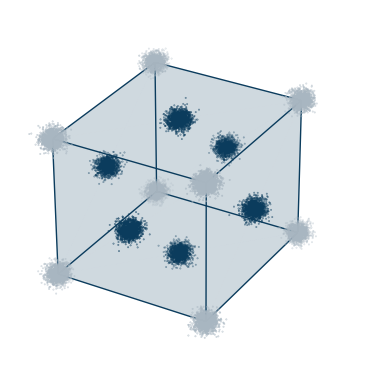

In [13]:
# Cubic solid cut off from Nickel (length=1) - center
lim = {'x': [-0.2,4.5], 'y': [-0.2,4], 'z': [-0.2,3.7]}
plot_solid(lim, center=True, filename='../figs/nickel/cubic_solid_nickel_samples_center_nobackground.png', style=bg_mpl_style)

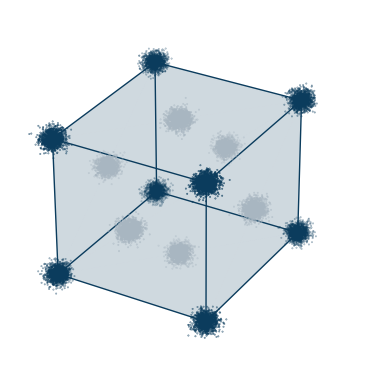

In [16]:
# Cubic solid cut off from Nickel (length=1) - corner
lim = {'x': [-0.2,4.5], 'y': [-0.2,4], 'z': [-0.2,3.7]}
plot_solid(lim, center=False, filename='../figs/nickel/cubic_solid_nickel_samples_corner_nobackground.png', style=bg_mpl_style)

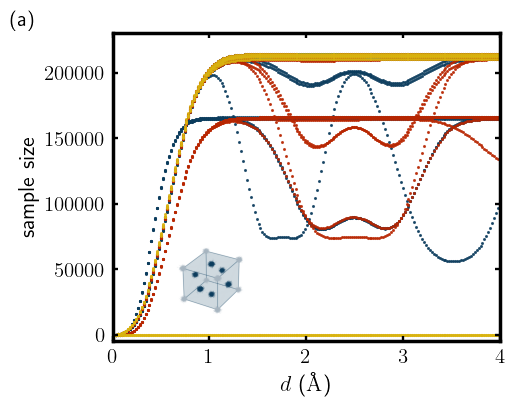

In [90]:
# sample size - center
plot(angle_keys=[0,45,90], center_key='center', sample_size_key='_samplesize', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel='sample size', xlim=[0,4], ylim=[-5000,230000], 
     filename='../figs/nickel/rotation_center_samplesize.png', style=bg_mpl_style, 
     text={'content':'(a)', 'loc':[-0.08, .9, 0, 0]}, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_center_nobackground.png', 'loc':[0.22, 0.15, 0.22, 0.22]})

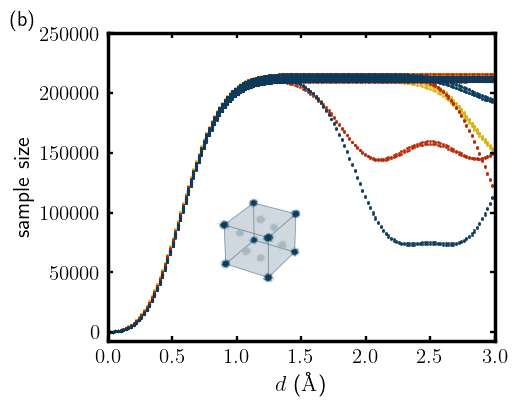

In [91]:
# sample size - corner
plot(angle_keys=[90, 45 ,0], center_key='corner', sample_size_key='_samplesize', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel='sample size', xlim=[0,3], ylim=[-8000,250000], 
     filename='../figs/nickel/rotation_corner_samplesize.png', style=bg_mpl_style, 
     text={'content':'(b)', 'loc':[-0.07, .9, 0, 0]}, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_corner_nobackground.png', 'loc':[0.30, 0.22, 0.28, 0.28]})

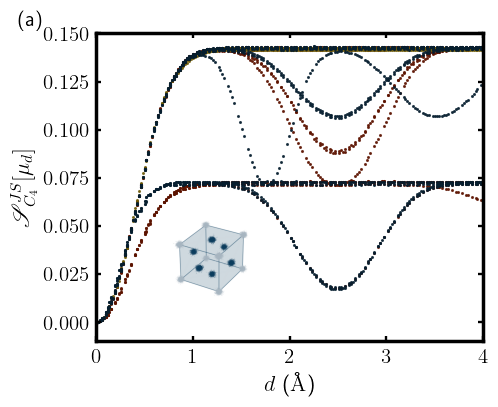

In [103]:
# center
plot(angle_keys=[45,90,0], center_key='center', sample_size_key='', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{JS}_{C_4}[\mu_d]$',
     xlim=[0,4], ylim=[-0.01,0.15], 
     filename='../figs/nickel/rotation_center.png', style=bg_mpl_style, 
     text={'content':'(a)', 'loc':[-0.03, .9, 0, 0]}, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_center_nobackground.png', 'loc':[0.24, 0.19, 0.25, 0.25]})

In [93]:
def adjust_lightness(color, amount=0.5):
    # the color gets brighter when amount > 1 and darker when amount < 1
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [126]:
angle_keys = [0, 45, 90]
center_key = 'center'
sample_size_key = ''

# Function to process and assign data
def process_and_assign(data_chunk, data_key, start, end):
    # Select rows and extract x and y
    selected_rows = data_chunk[start:end]
    x_values, y_values = selected_rows[:, 0], selected_rows[:, 1]

    # Check if the target arrays are empty and initialize them if they are
    if data[data_key][center_key][sample_size_key]['x'].size == 0:
        data[data_key][center_key][sample_size_key]['x'] = x_values
    else:
        # Concatenate the new x values to the existing array, maintaining 1D structure
        data[data_key][center_key][sample_size_key]['x'] = np.concatenate((data[data_key][center_key][sample_size_key]['x'], x_values))

    if data[data_key][center_key][sample_size_key]['y'].size == 0:
        data[data_key][center_key][sample_size_key]['y'] = y_values
    else:
        # Concatenate the new y values to the existing array, maintaining 1D structure
        data[data_key][center_key][sample_size_key]['y'] = np.concatenate((data[data_key][center_key][sample_size_key]['y'], y_values))

# Loop over angle keys to load, process, and assign data
for angle, color, chunk_size, cutoff in [[0, BLUE, 12, 4], [45, RED, 12, 4], [90, YELLOW, 6, 2]]:
    # Load the dataset for the current angle
    data_full = np.loadtxt(f'../figs/nickel/rotation_perturbation_{angle}_{center_key}{sample_size_key}.csv', delimiter=',')
    data[angle][center_key][sample_size_key] = {'x':np.array([]), 'y':np.array([]), 'color':None}
    data[f'{angle}_light'] = {center_key: {sample_size_key: {'x':np.array([]), 'y':np.array([]), 'color':None}}}

    # Process the data in chunks of 30
    for start_idx in range(0, len(data_full), chunk_size):
        chunk = data_full[start_idx:start_idx+chunk_size]  
        process_and_assign(chunk, angle, 0, cutoff)
        process_and_assign(chunk, f'{angle}_light', cutoff, 2*cutoff)
        process_and_assign(chunk, angle, 2*cutoff, None)
    data[angle][center_key][sample_size_key]['color'] = adjust_lightness(color, amount=0.6)
    data[f'{angle}_light'][center_key][sample_size_key]['color'] = adjust_lightness(color, amount=1.8)

In [105]:
a=data[f'{45}_light'][center_key][sample_size_key]['y']
#data[0]['corner'][sample_size_key]

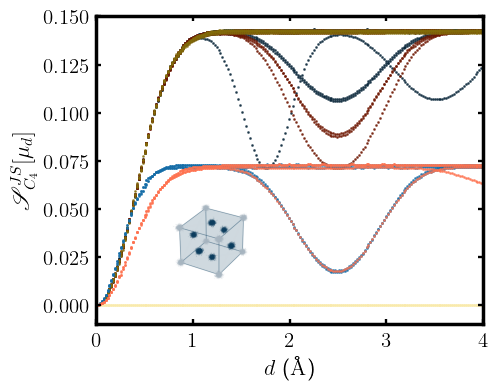

In [127]:
# center - no label
plot(angle_keys=[0,45,90,'0_light','90_light','45_light'], center_key='center', sample_size_key='', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{JS}_{C_4}[\mu_d]$',
     xlim=[0,4], ylim=[-0.01,0.15], 
     filename='../figs/nickel/rotation_center_nolabel.png', style=bg_mpl_style, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_center_nobackground.png', 'loc':[0.24, 0.19, 0.25, 0.25]})

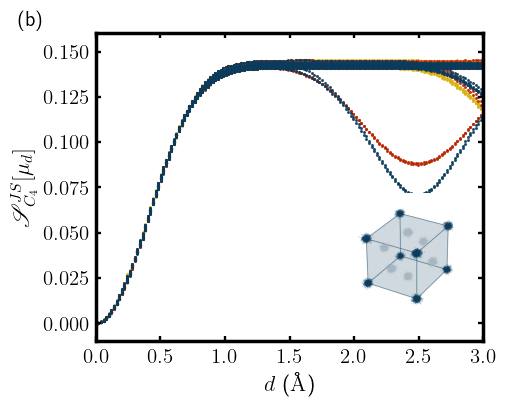

In [97]:
# corner
plot(angle_keys=[90, 45 ,0], center_key='corner', sample_size_key='', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{JS}_{C_4}[\mu_d]$',
     xlim=[0,3], ylim=[-0.01,0.16], 
     filename='../figs/nickel/rotation_corner.png', style=bg_mpl_style, 
     text={'content':'(b)', 'loc':[-0.03, .9, 0, 0]}, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_corner_nobackground.png', 'loc':[0.6, 0.16, 0.32, 0.32]})

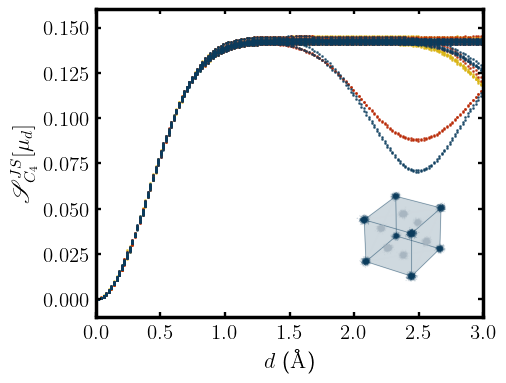

In [129]:
# corner - no label
plot(angle_keys=[90, 45 ,0], center_key='corner', sample_size_key='', 
     xlabel=r'$d$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{JS}_{C_4}[\mu_d]$',
     xlim=[0,3], ylim=[-0.01,0.16], 
     filename='../figs/nickel/rotation_corner_nolabel.png', style=bg_mpl_style, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_corner_nobackground.png', 'loc':[0.6, 0.16, 0.3, 0.3]})